# LSTM SPY Price prediction

Because we are working with options we are trying to predict SPY price on expiration day. Current example  try to predict SPY price a few days ahead (4 days in this example) using current available data (in this case 30 days).  In the image I showed how we want to predict price. 
![title](spy_data_example.png)


For this purpose we use LSTM with two LSTM layers and 128 neurons per layer. You can find model in [Build_model_function](#build_model)


As a datasource we use Alpaca SPY OHLCV data. SPY trades according to Alpaca data from 9:00 UTC till 24:00. We use hourly data so one day = 15 datasamples. In this case we need to predict the price for 60 datasamples ahead. And for predict this we use 30 days window (450 datasamples). In this example we don’t take to account weekends and holidays. So in some cases the real prediction date may be more than 4 days. 

In this notebook in the first part you can find how the model was trained and in the [second part](#section2)  you can find how the model predicts.  For trains we use a dataframe from 2021-12-01 to 2022-04-01. For prediction we use 2022-03 and 2022-04 data. For test prediction we use part of 2022-03 because we need a 30 days window of data. 


Questions: 

* Give your opinion regarding the statement:  OHLCV for some period can predict some price in future with good probability.
* Current model does not work well.  If the main logic have right to life could you advise what we need to change in our model to improve it.
* What else can we add to our model other than OHLCV data to predict price more carefully?
* What do you think about the model that we use? 
* Can you advise the best time frame for model trains? 



In [227]:
!pip install numpy
!pip install pandas
!pip install alpaca-trade-api
!pip install vectorbt
!pip install matplotlib
!pip install scipy
!pip install tensorflow
!pip install keras
!pip install seaborn
!pip install sklearn

In [125]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 8

RANDOM_SEED = 42

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [201]:
import vectorbt as vbt
from datetime import datetime
from datetime import timezone
vbt.settings.data['alpaca']['key_id'] = 'PK0983A8QEZRZ7VKQTW7'
vbt.settings.data['alpaca']['secret_key'] = 'Nma8beOCO8ELuK2ZCpNdMJJJOzRTae5u4LClBQ9F'

start_time = datetime(2021,12,1,0,0,0, tzinfo=timezone.utc)
end_time = datetime(2022,4,2,0,0,0, tzinfo=timezone.utc)
# print(dir(vbt.AlpacaData))
# Alpaca fetch only 500 rows. So here is a crutch for data fetching.
df = None
while True:
    data = vbt.AlpacaData.download(
                'SPY',
                start=start_time,
                end=end_time,
                timeframe='1h')
    tmp_df = data.data['SPY']
    df = pd.concat([df, tmp_df])
    start_time = tmp_df.iloc[-1].name + pd.Timedelta(hours=1)
    if start_time == end_time or start_time > end_time:
        break

print(f'fetched data {df.shape[0]} from {df.iloc[0].name} to  {df.iloc[-1].name}')

fetched data 1356 from 2021-12-01 00:00:00+00:00 to  2022-04-01 23:00:00+00:00


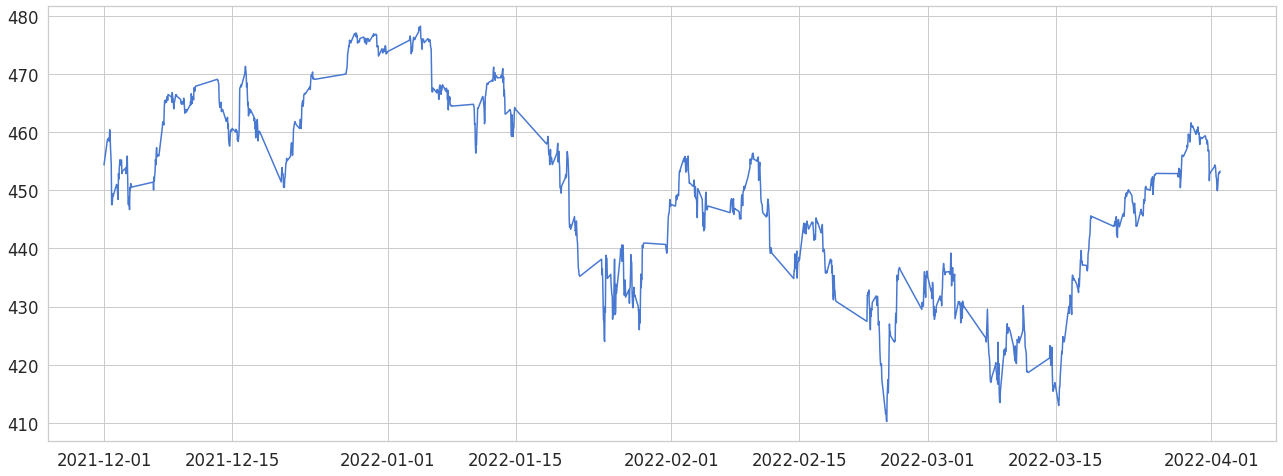

In [202]:
plt.plot(df.Close)
plt.show()

# Scale data

In [203]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x = df[['Open', 'Low', 'High', 'Volume']].copy()
y = df['Close'].copy()

x[['Open', 'Low', 'High', 'Volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))


# Split data to train and test datasets

In [204]:
def load_data(X, seq_len, delta = 60, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    Y = []
    for index in range(len(X_mat) - sequence_length - delta):
        # In this code we said  that our data predicts some value in future. 
        # For example, the interval 2021-12-01 - 2021-12-30 predicted a close price in 2022-01-03.
        # in this example sequence_length = 451 = 30 days of data
        # delta = 60 = 4 days of data
        data.append(X_mat[index: index + sequence_length])        
        Y.append(X_mat[index + sequence_length + delta])
    print(f'len of data: {len(data)}')
    data = np.array(data)
    Y = np.array(Y)
    train_split = int(round(train_size * data.shape[0]))
    x_train = data[:train_split, :]
    y_train = Y[:train_split, :]
    x_train = x_train[:, :-1]
    print(f'x_train {x_train}')
    y_train = y_train[:, -1]
    print(f'y_train {y_train}')
    x_test = data[train_split:, :-1] 
    y_test = Y[train_split:, :-1]
    y_test = y_test[:, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test, data

In [205]:
window = 450
offset = 60
# window = 128
# offset = 24
x['Close'] = y

X_train, y_train, X_test, y_test, data = load_data(x, window, delta=offset)
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#print (X_train[0], y_train[0])


len of data: 845
x_train [[[6.59414964e-01 7.88599405e-01 6.56273535e-01 3.13212489e-03
   6.49360200e-01]
  [6.87637807e-01 8.16576325e-01 7.07184817e-01 1.30279693e-03
   7.13193117e-01]
  [7.13508746e-01 8.27767092e-01 7.02816689e-01 6.06722169e-04
   7.12751875e-01]
  ...
  [8.21108335e-01 8.90452876e-01 8.12170508e-01 6.96839572e-04
   8.13354905e-01]
  [8.11406732e-01 8.85207204e-01 8.07953005e-01 2.18742177e-03
   8.02765113e-01]
  [8.14787594e-01 8.73841581e-01 8.18496762e-01 8.19609482e-03
   7.91145757e-01]]

 [[6.87637807e-01 8.16576325e-01 7.07184817e-01 1.30279693e-03
   7.13193117e-01]
  [7.13508746e-01 8.27767092e-01 7.02816689e-01 6.06722169e-04
   7.12751875e-01]
  [7.13508746e-01 8.26280818e-01 7.05678566e-01 2.32269551e-03
   7.15840565e-01]
  ...
  [8.11406732e-01 8.85207204e-01 8.07953005e-01 2.18742177e-03
   8.02765113e-01]
  [8.14787594e-01 8.73841581e-01 8.18496762e-01 8.19609482e-03
   7.91145757e-01]
  [7.90239600e-01 8.48662354e-01 7.82196114e-01 1.75006776e

<a id='build_model'></a>

In [206]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [207]:
model = build_model(input_shape=(window, 5))

In [208]:
history = model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=2)

Epoch 1/500
24/24 - 14s - loss: 0.0736 - accuracy: 0.0013 - 14s/epoch - 588ms/step
Epoch 2/500
24/24 - 12s - loss: 0.0277 - accuracy: 0.0013 - 12s/epoch - 504ms/step
Epoch 3/500
24/24 - 12s - loss: 0.0283 - accuracy: 0.0013 - 12s/epoch - 516ms/step
Epoch 4/500
24/24 - 13s - loss: 0.0276 - accuracy: 0.0013 - 13s/epoch - 547ms/step
Epoch 5/500
24/24 - 14s - loss: 0.0272 - accuracy: 0.0013 - 14s/epoch - 566ms/step
Epoch 6/500
24/24 - 13s - loss: 0.0271 - accuracy: 0.0013 - 13s/epoch - 546ms/step
Epoch 7/500
24/24 - 13s - loss: 0.0280 - accuracy: 0.0013 - 13s/epoch - 548ms/step
Epoch 8/500
24/24 - 13s - loss: 0.0266 - accuracy: 0.0013 - 13s/epoch - 550ms/step
Epoch 9/500
24/24 - 13s - loss: 0.0267 - accuracy: 0.0013 - 13s/epoch - 549ms/step
Epoch 10/500
24/24 - 13s - loss: 0.0265 - accuracy: 0.0013 - 13s/epoch - 559ms/step
Epoch 11/500
24/24 - 20s - loss: 0.0238 - accuracy: 0.0013 - 20s/epoch - 830ms/step
Epoch 12/500
24/24 - 23s - loss: 0.0229 - accuracy: 0.0013 - 23s/epoch - 968ms/step
E

Epoch 99/500
24/24 - 21s - loss: 0.0200 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 100/500
24/24 - 21s - loss: 0.0201 - accuracy: 0.0013 - 21s/epoch - 873ms/step
Epoch 101/500
24/24 - 21s - loss: 0.0160 - accuracy: 0.0013 - 21s/epoch - 878ms/step
Epoch 102/500
24/24 - 21s - loss: 0.0193 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 103/500
24/24 - 21s - loss: 0.0242 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 104/500
24/24 - 21s - loss: 0.0223 - accuracy: 0.0013 - 21s/epoch - 872ms/step
Epoch 105/500
24/24 - 21s - loss: 0.0207 - accuracy: 0.0013 - 21s/epoch - 876ms/step
Epoch 106/500
24/24 - 21s - loss: 0.0187 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 107/500
24/24 - 21s - loss: 0.0166 - accuracy: 0.0013 - 21s/epoch - 873ms/step
Epoch 108/500
24/24 - 21s - loss: 0.0190 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 109/500
24/24 - 22s - loss: 0.0170 - accuracy: 0.0013 - 22s/epoch - 900ms/step
Epoch 110/500
24/24 - 21s - loss: 0.0189 - accuracy: 0.0013 - 21s/

Epoch 196/500
24/24 - 21s - loss: 0.0098 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 197/500
24/24 - 21s - loss: 0.0107 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 198/500
24/24 - 21s - loss: 0.0092 - accuracy: 0.0013 - 21s/epoch - 876ms/step
Epoch 199/500
24/24 - 21s - loss: 0.0081 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 200/500
24/24 - 21s - loss: 0.0070 - accuracy: 0.0013 - 21s/epoch - 876ms/step
Epoch 201/500
24/24 - 21s - loss: 0.0179 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 202/500
24/24 - 21s - loss: 0.0162 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 203/500
24/24 - 21s - loss: 0.0153 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 204/500
24/24 - 21s - loss: 0.0140 - accuracy: 0.0013 - 21s/epoch - 876ms/step
Epoch 205/500
24/24 - 21s - loss: 0.0143 - accuracy: 0.0013 - 21s/epoch - 876ms/step
Epoch 206/500
24/24 - 21s - loss: 0.0151 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 207/500
24/24 - 21s - loss: 0.0138 - accuracy: 0.0013 - 21s

Epoch 293/500
24/24 - 21s - loss: 0.0126 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 294/500
24/24 - 21s - loss: 0.0098 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 295/500
24/24 - 21s - loss: 0.0101 - accuracy: 0.0013 - 21s/epoch - 878ms/step
Epoch 296/500
24/24 - 21s - loss: 0.0080 - accuracy: 0.0013 - 21s/epoch - 882ms/step
Epoch 297/500
24/24 - 21s - loss: 0.0060 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 298/500
24/24 - 21s - loss: 0.0067 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 299/500
24/24 - 21s - loss: 0.0073 - accuracy: 0.0013 - 21s/epoch - 880ms/step
Epoch 300/500
24/24 - 21s - loss: 0.0079 - accuracy: 0.0013 - 21s/epoch - 878ms/step
Epoch 301/500
24/24 - 21s - loss: 0.0065 - accuracy: 0.0013 - 21s/epoch - 882ms/step
Epoch 302/500
24/24 - 21s - loss: 0.0051 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 303/500
24/24 - 21s - loss: 0.0040 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 304/500
24/24 - 21s - loss: 0.0046 - accuracy: 0.0013 - 21s

Epoch 390/500
24/24 - 21s - loss: 0.0025 - accuracy: 0.0013 - 21s/epoch - 881ms/step
Epoch 391/500
24/24 - 21s - loss: 0.0022 - accuracy: 0.0013 - 21s/epoch - 881ms/step
Epoch 392/500
24/24 - 22s - loss: 0.0022 - accuracy: 0.0013 - 22s/epoch - 900ms/step
Epoch 393/500
24/24 - 23s - loss: 0.0021 - accuracy: 0.0013 - 23s/epoch - 963ms/step
Epoch 394/500
24/24 - 21s - loss: 0.0021 - accuracy: 0.0013 - 21s/epoch - 874ms/step
Epoch 395/500
24/24 - 21s - loss: 0.0020 - accuracy: 0.0013 - 21s/epoch - 877ms/step
Epoch 396/500
24/24 - 21s - loss: 0.0021 - accuracy: 0.0013 - 21s/epoch - 874ms/step
Epoch 397/500
24/24 - 21s - loss: 0.0022 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 398/500
24/24 - 21s - loss: 0.0019 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 399/500
24/24 - 21s - loss: 0.0017 - accuracy: 0.0013 - 21s/epoch - 881ms/step
Epoch 400/500
24/24 - 21s - loss: 0.0019 - accuracy: 0.0013 - 21s/epoch - 870ms/step
Epoch 401/500
24/24 - 21s - loss: 0.0023 - accuracy: 0.0013 - 21s

Epoch 487/500
24/24 - 21s - loss: 9.2567e-04 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 488/500
24/24 - 21s - loss: 9.3715e-04 - accuracy: 0.0013 - 21s/epoch - 874ms/step
Epoch 489/500
24/24 - 21s - loss: 9.6843e-04 - accuracy: 0.0013 - 21s/epoch - 874ms/step
Epoch 490/500
24/24 - 21s - loss: 9.4427e-04 - accuracy: 0.0013 - 21s/epoch - 879ms/step
Epoch 491/500
24/24 - 21s - loss: 9.9696e-04 - accuracy: 0.0013 - 21s/epoch - 872ms/step
Epoch 492/500
24/24 - 21s - loss: 9.3365e-04 - accuracy: 0.0013 - 21s/epoch - 872ms/step
Epoch 493/500
24/24 - 21s - loss: 0.0010 - accuracy: 0.0013 - 21s/epoch - 871ms/step
Epoch 494/500
24/24 - 21s - loss: 0.0010 - accuracy: 0.0013 - 21s/epoch - 875ms/step
Epoch 495/500
24/24 - 21s - loss: 0.0010 - accuracy: 0.0013 - 21s/epoch - 873ms/step
Epoch 496/500
24/24 - 21s - loss: 9.2205e-04 - accuracy: 0.0013 - 21s/epoch - 873ms/step
Epoch 497/500
24/24 - 21s - loss: 9.6387e-04 - accuracy: 0.0013 - 21s/epoch - 873ms/step
Epoch 498/500
24/24 - 21s - loss:

In [ ]:
y_train

In [ ]:
y_test

In [209]:
save_model(model, "spy_model_window_450_ofset_60.h5")

In [210]:
model = load_model("spy_model_window_450_ofset_60.h5")


In [211]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [212]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

In [213]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 1.82 RMSE
Test Score: 37.18 RMSE


In [214]:
stock_prices = df.Close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [215]:
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window+offset:len(trainPredict)+window+offset, :] = trainPredict

testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(stock_prices) - testPredict.shape[0]):len(stock_prices), :] = testPredict

In [216]:
#plt.plot(pd.DataFrame(google_stock_prices, columns=["Close"], index=df.index).Close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["Close"], index=df.index).Close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["Close"], index=df.index).Close, label='Testing')
plt.plot(pd.DataFrame(stock_prices, columns=["Close"], index=df.index).Close, label='Actual')
plt.legend(loc='best')
plt.show()

<a id='section2'></a>

In [217]:
# save priveous data
train_df = df.copy() 

In [218]:
start_time = datetime(2022,3,1,0,0,0, tzinfo=timezone.utc)
end_time = datetime(2022,4,29,23,59,59, tzinfo=timezone.utc)
# print(dir(vbt.AlpacaData))
# Alpaca fetch only 500 rows. So here is a crutch for data fetching.
df = None
while True:
    data = vbt.AlpacaData.download(
                'SPY',
                start=start_time,
                end=end_time,
                timeframe='1h')
    tmp_df = data.data['SPY']
    df = pd.concat([df, tmp_df])
    start_time = tmp_df.iloc[-1].name + pd.Timedelta(hours=1)
    if start_time == end_time or start_time > end_time:
        break

print(f'fetched data {df.shape[0]} from {df.iloc[0].name} to  {df.iloc[-1].name}')

fetched data 691 from 2022-03-01 00:00:00+00:00 to  2022-04-29 23:00:00+00:00


In [219]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x = df[['Open', 'Low', 'High', 'Volume']].copy()
y = df['Close'].copy()

x[['Open', 'Low', 'High', 'Volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
x['Close'] = y

## Use the same function to prepare data but use train_size =1 all data will be in X_train. Will use it for prediction.

In [220]:
X_train, y_train, X_test, y_test, data = load_data(x, window, delta=offset, train_size=1)

len of data: 180
x_train [[[4.88893376e-01 4.72009666e-01 4.69328942e-01 2.77017340e-03
   4.68213925e-01]
  [4.70920840e-01 4.28312525e-01 4.56978180e-01 2.87257501e-03
   4.16750757e-01]
  [4.18618740e-01 4.05155054e-01 4.04281597e-01 2.70957567e-03
   4.24823411e-01]
  ...
  [7.35460420e-01 7.50503423e-01 7.27871552e-01 1.45802473e-03
   7.38446014e-01]
  [7.39499192e-01 7.53121224e-01 7.37546315e-01 5.78572086e-04
   7.50554995e-01]
  [7.76453958e-01 7.79299235e-01 7.72128448e-01 7.14782736e-04
   7.64883956e-01]]

 [[4.70920840e-01 4.28312525e-01 4.56978180e-01 2.87257501e-03
   4.16750757e-01]
  [4.18618740e-01 4.05155054e-01 4.04281597e-01 2.70957567e-03
   4.24823411e-01]
  [4.17810985e-01 3.93475634e-01 4.07163442e-01 2.64539816e-03
   3.90514632e-01]
  ...
  [7.39499192e-01 7.53121224e-01 7.37546315e-01 5.78572086e-04
   7.50554995e-01]
  [7.76453958e-01 7.79299235e-01 7.72128448e-01 7.14782736e-04
   7.64883956e-01]
  [7.58279483e-01 7.71043093e-01 7.46809387e-01 2.20773021e

In [221]:
trainPredict = model.predict(X_train)

In [222]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])

In [223]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 13.66 RMSE


In [224]:
stock_prices = df.Close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [225]:
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window+offset:len(trainPredict)+window+offset, :] = trainPredict

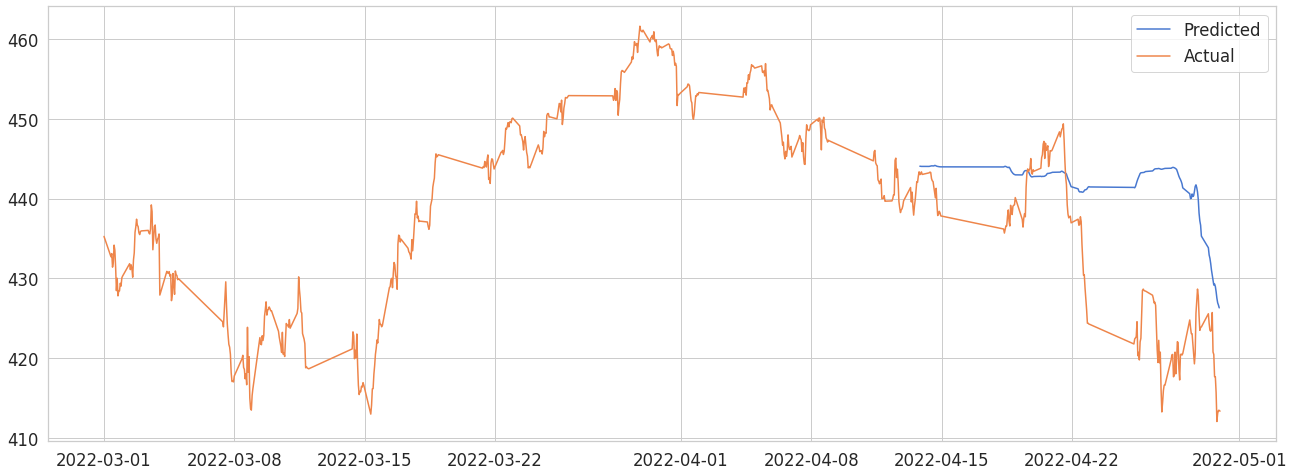

In [226]:
#plt.plot(pd.DataFrame(google_stock_prices, columns=["Close"], index=df.index).Close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["Close"], index=df.index).Close, label='Predicted')
# plt.plot(pd.DataFrame(testPredictPlot, columns=["Close"], index=df.index).Close, label='Testing')
plt.plot(pd.DataFrame(stock_prices, columns=["Close"], index=df.index).Close, label='Actual')
plt.legend(loc='best')
plt.show()

From this test you can see that prediction works bad and we have a very big RMSE =13.66 . Is it a problem of our approach or do we need to change models etc.? 